#1. Self-Attention
Self-Attention is a mechanism that computes the relevance of each element in a sequence with respect to all other elements **in the same sequence**. It is widely used in natural language processing (NLP) to capture dependencies within a sequence.
* **Input**: A single sequence (e.g., a sequence of word embeddings from a sentence).
* **Purpose**: It calculates relationships between elements within the same input sequence to better understand the context.

**Formula**:

For an input sequence $X = [x_1, x_2, ..., x_n]$, Self-Attention is computed as:


$$ \text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right)V $$


where *Q* , *K*, and *V* are the Query, Key, and Value matrices derived from the input *X*.

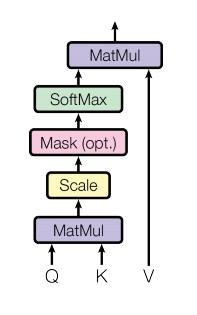


In [ ]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embedding size must be divisible by heads"

        self.values = nn.Linear(self.head_dim, embed_size, bias=False)
        self.keys = nn.Linear(self.head_dim, embed_size, bias=False)
        self.queries = nn.Linear(self.head_dim, embed_size, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        energy = torch.matmul(queries.transpose(1, 2), keys.transpose(1, 2).transpose(2, 3))  # (n, h, q, k)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
        attention = torch.softmax(energy / (self.embed_size ** 0.5), dim=3)

        out = torch.matmul(attention, values.transpose(1, 2))  # (n, h, q, d)
        out = out.transpose(1, 2).contiguous().view(N, query_len, self.heads * self.head_dim)  # Reshape

        out = self.fc_out(out)
        return out


#2. Cross-Attention
Cross-Attention computes the attention between two different sequences: one sequence is used as the query, while the other sequence is used as the key and value. This is commonly used in transformer decoders, where information from the encoder is used to compute the attention.
* **Input**: Two sequences (e.g., query from a decoder and key and value from an encoder).
* **Purpose**: It allows information transfer between different sequences, commonly seen in encoder-decoder architectures.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CrossAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(CrossAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size must be divisible by heads"

        # Layers for queries, keys, and values
        self.query_layer = nn.Linear(embed_size, embed_size)
        self.key_layer = nn.Linear(embed_size, embed_size)
        self.value_layer = nn.Linear(embed_size, embed_size)

        # Final output linear layer
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, query, key, value, mask=None):
        N = query.shape[0]  # Batch size
        query_len, key_len, value_len = query.shape[1], key.shape[1], value.shape[1]

        # Linear projections to obtain Q, K, V
        Q = self.query_layer(query)  # Shape: (N, query_len, embed_size)
        K = self.key_layer(key)      # Shape: (N, key_len, embed_size)
        V = self.value_layer(value)  # Shape: (N, value_len, embed_size)

        # Reshape for multi-head attention
        Q = Q.reshape(N, query_len, self.heads, self.head_dim).transpose(1, 2)  # (N, heads, query_len, head_dim)
        K = K.reshape(N, key_len, self.heads, self.head_dim).transpose(1, 2)    # (N, heads, key_len, head_dim)
        V = V.reshape(N, value_len, self.heads, self.head_dim).transpose(1, 2)  # (N, heads, value_len, head_dim)

        # Calculate the attention scores: Q * K^T / sqrt(d_k)
        energy = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (N, heads, query_len, key_len)

        # Apply mask (if provided)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Softmax to get the attention weights
        attention = F.softmax(energy, dim=-1)  # (N, heads, query_len, key_len)

        # Multiply attention weights with V
        out = torch.matmul(attention, V)  # (N, heads, query_len, head_dim)

        # Reshape the output and pass it through the final linear layer
        out = out.transpose(1, 2).contiguous().view(N, query_len, self.embed_size)  # (N, query_len, embed_size)
        out = self.fc_out(out)  # (N, query_len, embed_size)

        return out


#3. Multi-Head Attention
Multi-Head Attention consists of multiple independent attention mechanisms (heads) run in parallel. The outputs of these attention heads are then concatenated and passed through a linear layer. This allows the model to capture information from different subspaces simultaneously, enhancing the model's representational power.
* **Input**: Can be input sequences for self-attention or cross-attention.
* **Purpose**: Enhances the representational capacity of the model by using multiple attention heads in parallel.

**Formula**:
$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, ..., \text{head}_h)W^O $$
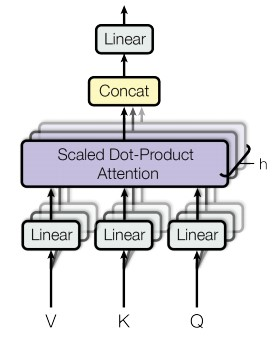

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        self.heads = heads
        self.self_attention = SelfAttention(embed_size, heads)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask):
        # Perform multi-head self-attention
        attention = self.self_attention(values, keys, query, mask)
        return self.fc_out(attention)


#4. [Multi-Head Latent Attention](https://medium.com/towards-data-science/deepseek-v3-explained-1-multi-head-latent-attention-ed6bee2a67c4)
Multi-Head Latent Attention (MLA) is an advanced variant of the traditional multi-head attention mechanism, introduced in the DeepSeek-V2 language model. Its primary goal is to reduce memory consumption during inference by compressing key and value representations into a lower-dimensional latent space. This compression not only decreases the size of the Key-Value (KV) cache but also enhances computational efficiency.

**Key Features of MLA**:

- **Low-Rank Decomposition**: MLA employs a low-rank factorization approach, projecting the original key and value vectors into a compressed latent space. This process involves two main steps:

  - **Down-Projection**: The input vector is projected from its original high-dimensional space to a lower-dimensional latent space.
  - **Up-Projection**: The compressed latent vector is then projected back to the original high-dimensional space to reconstruct the key and value vectors.
- **Memory Efficiency**: By storing only the compressed latent vectors in the KV cache during inference, MLA significantly reduces memory usage, reportedly to just 5–13% of what the traditional Multi-Head Attention (MHA) architecture consumes.


- **Performance Retention**: Unlike other methods that reduce memory overhead at the cost of performance, MLA maintains or even improves model performance. This is achieved by decompressing the latent vectors to yield unique and appropriate key and value pairs for each query head, ensuring the richness of the attention mechanism is preserved.


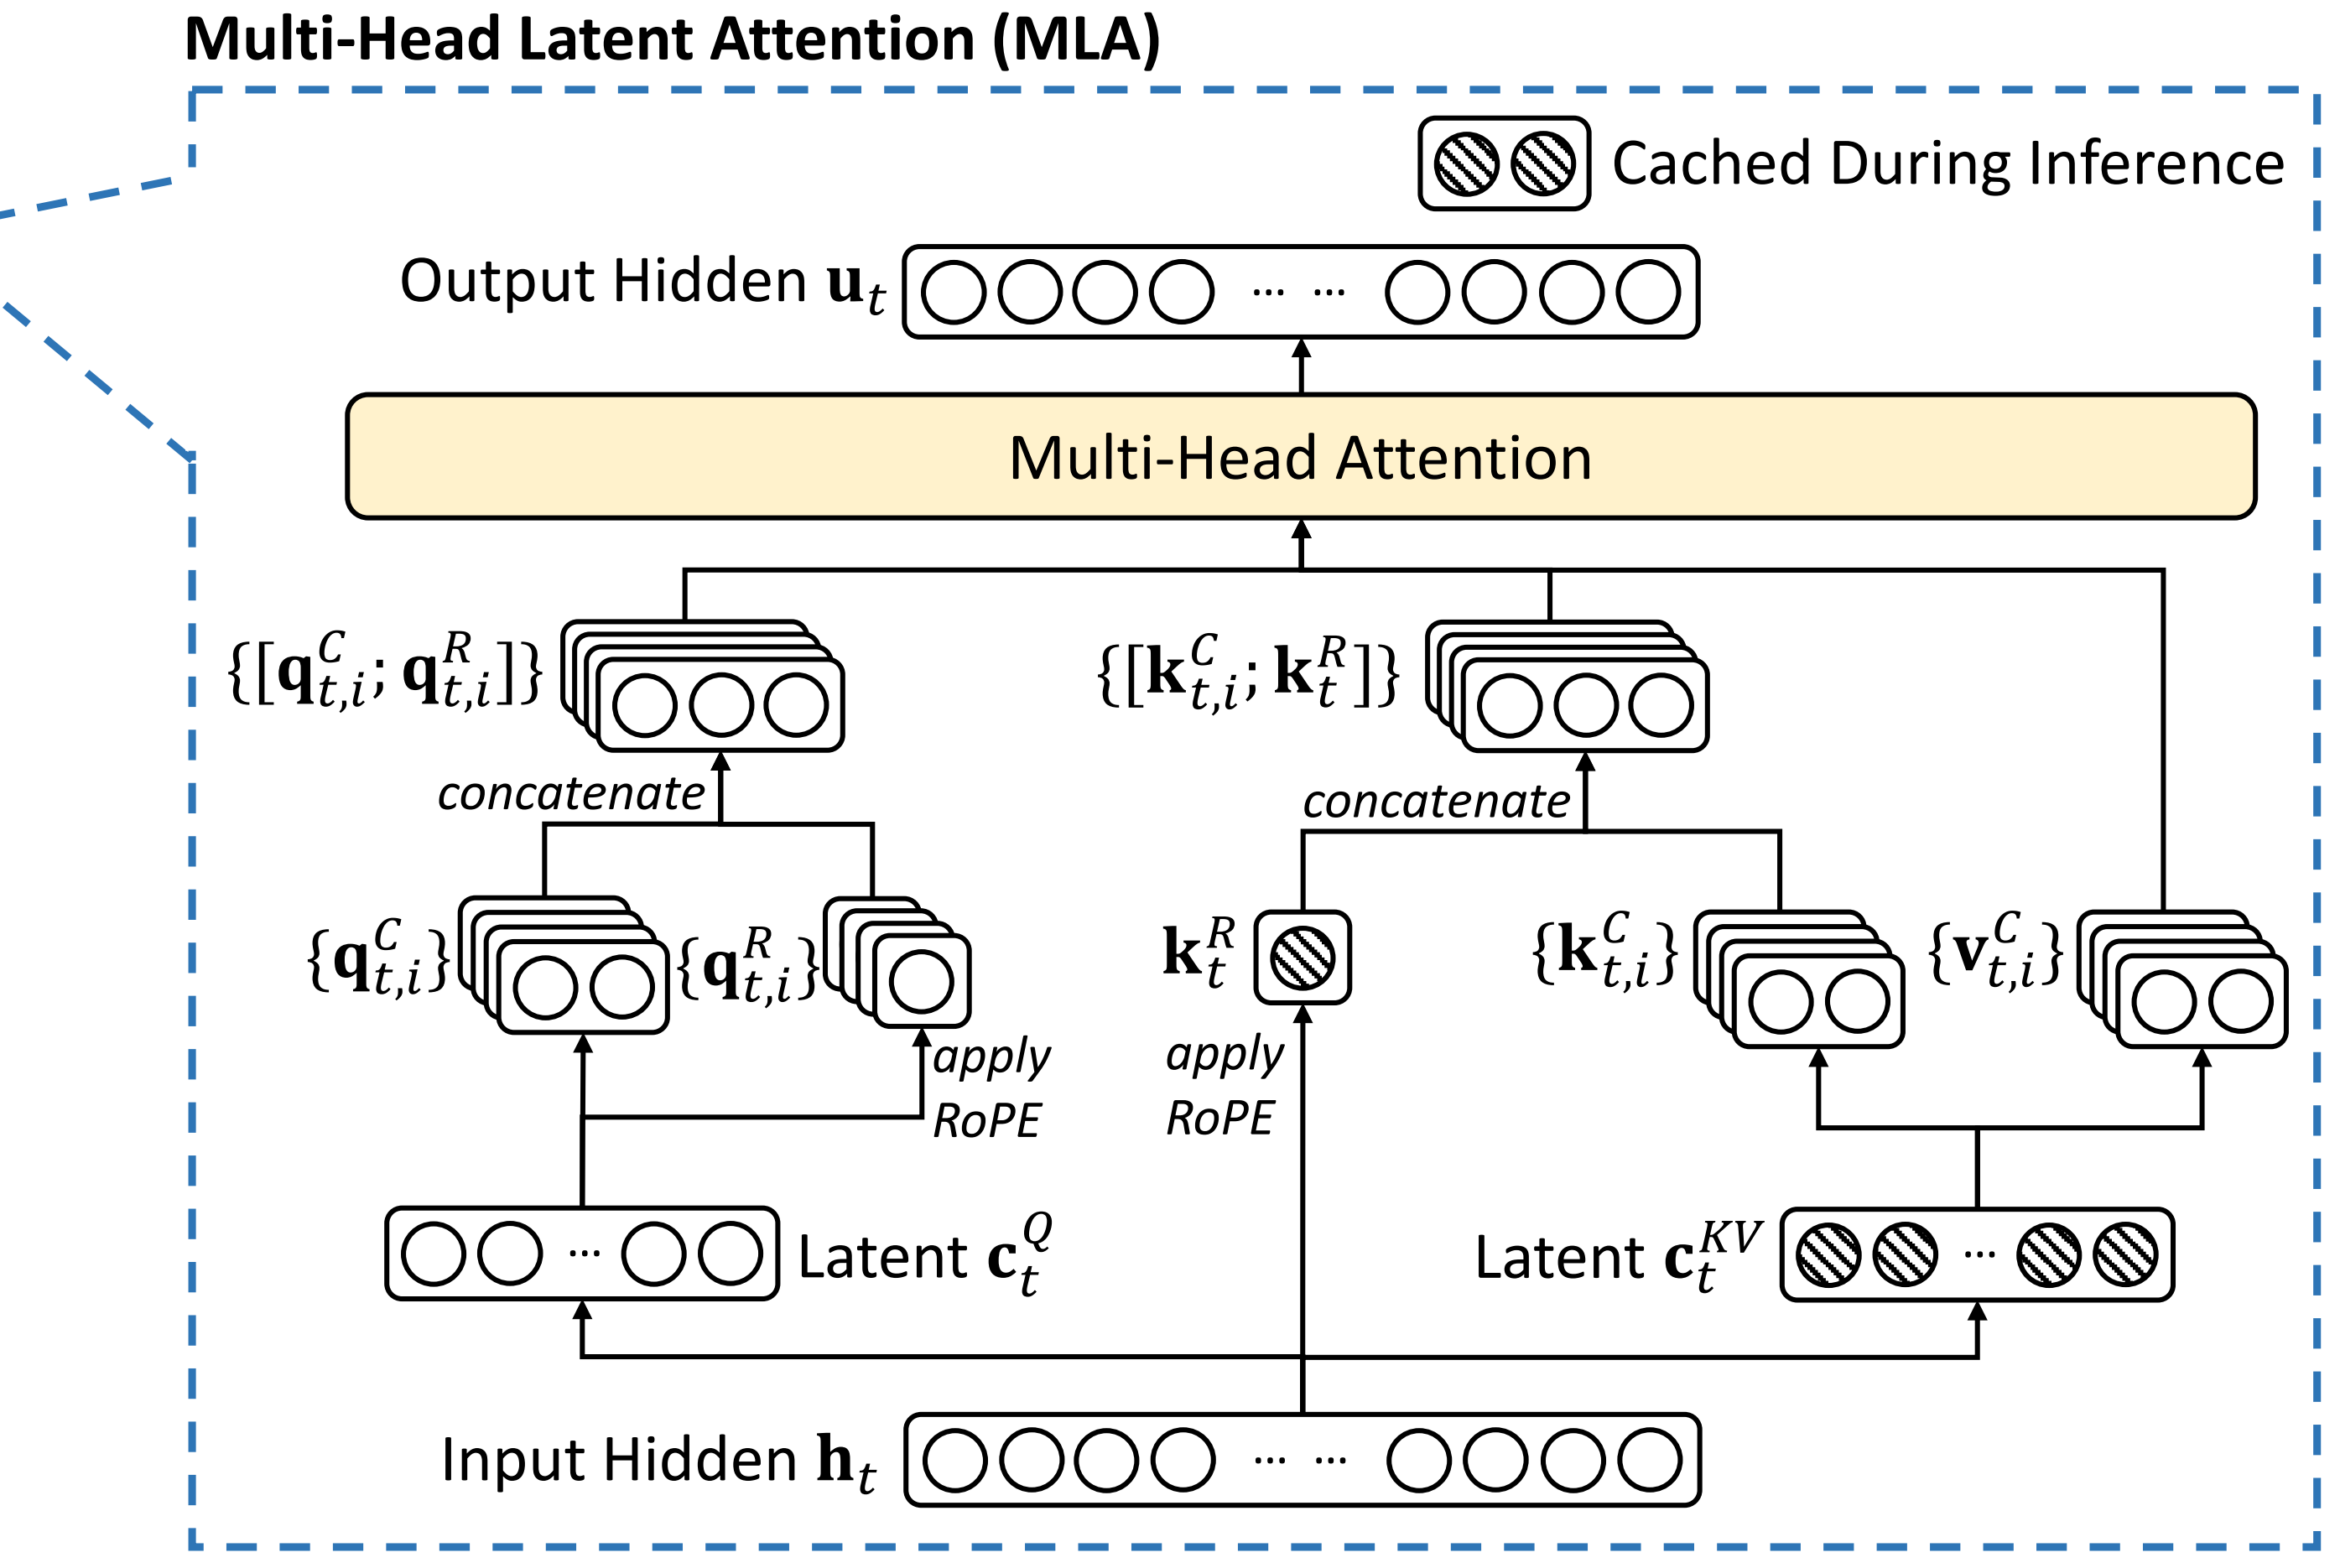

In [ ]:
@dataclass
class DeepseekConfig:
  hidden_size: int
  num_heads: int
  max_seq_len: int # a parameter related to rope
  rope_theta: float #frequency, mostly a large nubmer
  attention_dropout: float

  q_lora_rank: int # shape of latent, mostly a large number: 10000+
  qk_rope_head_dim: int # small number: 64
  kv_lora_rank: int # formula 41, small number: 512
  v_head_dim: int # 128
  qk_nope_head_dim: int
  attention_bias: bool

class MLA(nn.Module):
  def __init__(self, config):
    super().__init__()
    # MHA part
    self.attention_dropout = config.attention_dropout
    self.hidden_size = config.hidden_size
    self.num_heads = config.num_heads
    self.v_head_dim = config.v_head_dim

    self.out_proj = nn.Linear(self.num_heads * self.v_head_dim, self.hidden_size,
                              bias=config.attention_bias # not necessary
                  )
    # MLA compression
    # down
    self.qk_nope_head_dim = config.qk_nope_head_dim
    self.qk_rope_head_dim = config.qk_rope_head_dim

    self.q_lora_rank = config.q_lora_rank # 7168 -> 1536: compression rate is 1/4.7

    self.kv_lora_rank = config.kv_lora_rank # consist of two parts

    self.q_down_proj = nn.Linear(
        self.hidden_size, self.q_lora_rank, bias=config.attention_bias
    )
    self.q_down_norm = nn.LayerNorm(self.q_lora_rank) # DeepseekV2RMSNorm

    self.kv_down_proj = nn.Linear(
        self.hidden_size, self.kv_lora_rank + config.qk_rope_head_dim, bias=config.attention_bias
    ) # qk_rope_head_dim is very small, normally 64
    self.kv_down_norm = nn.LayerNorm(self.kv_lora_rank) # DeepseekV2RMSNorm


    # up & split
    self.q_head_dim = config.qk_rope_head_dim + config.qk_nope_head_dim
    self.q_up_proj = nn.Linear(
        self.q_lora_rank, self.num_heads * self.q_head_dim, bias=config.attention_bias
    )


    self.kv_up_proj = nn.Linear(
        self.kv_lora_rank, self.num_heads * (
            self.q_head_dim - config.qk_rope_head_dim + self.v_head_dim
        ), bias=config.attention_bias
    )

    # rope
    self.rotary_emb = RotaryEmbedding(
        dim=self.qk_rope_head_dim, embedding=config.max_position_embedding , theta=config.rope_theta
    )

  def forward(self, hidden_states, postion_ids, attention_mask=None):
    # hidden_statrs (b, seq_len, hidden_dim)
    bsz, q_len, _ = hidden_states.size()

    # 1. compression
    q = self.q_down_proj(hidden_states)
    q = self.q_down_norm(q)
    q = self.q_up_proj(q)
    # q shape: (b, seq_len,  self.num_heads * self.q_head_dim)
    q = q.view(bsz, seq_len, self.num_heads, self.q_head_dim).transpose(1, 2)
    # q shape: (b, self.num_heads, seq_len, self.q_head_dim)

    q_nope, q_rope = torch.split(q, [self.qk_nope_head_dim, self.qk_rope_head_dim], dim=-1)

    c_kv = self.kv_down_proj(hidden_states)
    c_kv, k_rope = torch.split(c_kv, [self.kv_lora_rank, self.qk_rope_head_dim], dim=-1)
    # k_rope shape: (bsz, seq_len, self.qk_rope_head_dim)
    k_rope = k_rope.view(bsz, seq_len, 1, self.qk_rope_head_dim).transpose(1, 2)
    # k_rope shape: (bsz, 1, seq_len, self.qk_rope_head_dim)
    kv = self.kv_down_proj(c_kv)
    kv = self.kv_down_norm(kv)
    kv = self.kv_up_proj(kv)

    # kv shape: (bsz, seq_len, self.num_heads * (self.q_head_dim - config.qk_rope_head_dim + self.v_head_dim))
    kv = kv.view(bsz, seq_len, self.num_heads, -1).transpose(1, 2)
    # kv shape: (bsz, self.num_heads, seq_len, self.v_head_dim + config.qk_nope_head_dim)

    k_nope, value_state = torch.split(kv, [self.qk_nope_head_dim, self.v_head_dim], dim=-1)

    # apply position encoding
    kv_seq_len = value_state.shape[-2]
    # value_state shape is (bsz, nums_head, seq_len, v_head_dim)

    cos, sin = self.rotary_emb(value_state, kv_seq_len)
    q_rope, k_rope = apply_rotary_pos_emb(q_rope, k_rope, cos, sin, position_ids)

    query_state = torch.cat((q_nope, q_rope), dim=-1)
    key_states = torch.concat(
            [k_nope, k_rope.expand(-1, self.num_heads, -1, -1)], dim=-1
        )
    # shape is (bsz, num_head, seq_len, head_dim = self.qk_rope_head_dim + self.qk_nope_head_dim)

    # 2. MHA
    attention_weights = torch.matmul(
        query_state, key_state.transpose(2,3)
    )
    attention_weights = attention_weights / math.sqrt(self.q_head_dim)
    if attention_mask is not None:
      # causal mask
      attention_weights = torch.masked_fill(attention_weights, attention_mask, -1e9)

    # softmax
    attention_weights = F.softmax(attention_weights, dim=-1)
    attention_weights = F.dropout(attention_weights, p=self.attention_dropout, training=self.training)

    output = torch.matmul(attention_weights, value_state)
    output = output.transpose(1, 2)
    output = output.reshape(bsz, seq_len, self.num_heads * self.v_head_dim)

    output = self.out_proj(output)
    return output, attention_weights


# Key Differences:
**Self-Attention:** Calculates attention within the same sequence, focusing on intra-sequence dependencies.

**Cross-Attention:** Calculates attention between two different sequences, allowing for inter-sequence information transfer.

**Multi-Head Attention:** Executes multiple attention heads in parallel, improving the model's capacity to capture diverse information.

**Multi-Head Latent Attention:** Employs a low-rank factorization approach, projecting the original key and value vectors into a compressed latent space

#Summary
**Self-Attention** focuses on dependencies within a sequence.

**Cross-Attention** focuses on interactions between two sequences.

**Multi-Head Attention** applies multiple attention mechanisms to improve the model's expressive power.

**Multi-Head Latent Attention** offers a more memory-efficient alternative to traditional multi-head attention mechanisms, achieving significant reductions in memory usage without compromising, and potentially enhancing, model performance.